# Setup

In [39]:
pip install pandas openpyxl pillow numpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import openpyxl
from PIL import Image
from PIL import Image, ImageDraw, ImageChops, ImageFont
import os

In [41]:
category = "2025"

df = pd.read_excel("data/Proto-2_Frame_Auto.xlsx", sheet_name=category)
df.head()


,full_name,short_name,k-id,birthday,anniversary,department,advance,pro,expert,habit_1,...,habit_4,habit_5,habit_6,shabit_5,th_2,habit_7,habit_8,habit_9,shabit_6,th_3
0,Mathew Sullivan,Mat Sullivan,m.sullivan,May,January,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Carter Guerrero,Cart Guerrero,c.guerrero,May,January,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marley Dale,Marl Dale,m.dale,May,Febuary,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Harold Griffith,Harry Griffith,h.griffith,May,Febuary,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alysha Davidson,Aly Davidson,a.davidson,May,Febuary,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter Values Birthday

In [42]:
# change value of this variable
bday_month = "May"
category = "birthday"

bday = df[(df[category] == bday_month)]

cleaned_bday = bday[["short_name", "k-id"]]
cleaned_bday

,short_name,k-id
0,Mat Sullivan,m.sullivan
1,Cart Guerrero,c.guerrero
2,Marl Dale,m.dale
3,Harry Griffith,h.griffith
4,Aly Davidson,a.davidson
5,Gerald Quinn,g.quinn
6,Mir Hernandez,m.hernandez
7,Mett Melendez,m.melendez
8,Sors Suarez,s.suarez
9,Bil Wilcox,b.wilcox


In [43]:
test = cleaned_bday.to_dict(orient='split', index=False)
bday = test['data']
bday

[['Mat Sullivan', 'm.sullivan'],
 ['Cart Guerrero', 'c.guerrero'],
 ['Marl Dale', 'm.dale'],
 ['Harry Griffith', 'h.griffith'],
 ['Aly Davidson', 'a.davidson'],
 ['Gerald Quinn', 'g.quinn'],
 ['Mir Hernandez', 'm.hernandez'],
 ['Mett Melendez', 'm.melendez'],
 ['Sors Suarez', 's.suarez'],
 ['Bil Wilcox', 'b.wilcox'],
 ['Lu Jefferson', 'l.jefferson'],
 ['Emman Hardy', 'e.hardy'],
 ['Jac Roberts', 'j.roberts']]

### Creating groups (to modify)

In [44]:
data = bday
groups = [] 
while data:
    n = len(data)
    for size in range(8, 0, -1):
        if n % size == 0 or n >= size:
            groups.append(data[:size])
            data = data[size:]
            break

for i, group in enumerate(groups, 1):
    print(f"Group {i} ({len(group)} members):", group)

Group 1 (8 members): [['Mat Sullivan', 'm.sullivan'], ['Cart Guerrero', 'c.guerrero'], ['Marl Dale', 'm.dale'], ['Harry Griffith', 'h.griffith'], ['Aly Davidson', 'a.davidson'], ['Gerald Quinn', 'g.quinn'], ['Mir Hernandez', 'm.hernandez'], ['Mett Melendez', 'm.melendez']]
Group 2 (5 members): [['Sors Suarez', 's.suarez'], ['Bil Wilcox', 'b.wilcox'], ['Lu Jefferson', 'l.jefferson'], ['Emman Hardy', 'e.hardy'], ['Jac Roberts', 'j.roberts']]


### Image Coordinates

In [47]:
single_y = 418
top_y = 328
bottom_y = 732

coord_arr_8 = [(51, top_y),(500, top_y),(948, top_y),(1396, top_y),
               (266, bottom_y),(714, bottom_y),(1163, bottom_y),(1611, bottom_y)]
coord_arr_7 = [(91, top_y),(589, top_y),(1087, top_y),(1585, top_y),
               (308, bottom_y),(838, bottom_y),(1367, bottom_y)]
coord_arr_6 = [(203, top_y),(733, top_y),(1262, top_y),
               (454, bottom_y),(983, bottom_y),(1513, bottom_y)]
coord_arr_5 = [(203, top_y), (838, top_y), (1472, top_y), 
               (518, bottom_y), (1158, bottom_y)]
coord_arr_4 = [(172, single_y),(616, single_y),(1060, single_y),(1504, single_y)]
coord_arr_3 = [(268, single_y),(838, single_y),(1408, single_y)]
coord_arr_2 = [(565, single_y),(1111, single_y)]
coord_arr_1 = [(838, single_y)]

## Notes

TODO: 
- calculate image and text offset to make the anchor point be the middle
- read the name and image path from the excel file 
- use the appropriate canvas when of number of people 

TODO: 
- Make this into a video, save it and get the duration 
- Set this duration in the software upload and observe how it will play

TODO:
- create folder for image and file in the downloads folder for easy access 
- detect if the file is an image or excel file 
- move them in their respective folders inside the project 

# Main Process

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os

# Coordinate mapping
coord_map = {
    8: coord_arr_8,
    7: coord_arr_7,
    6: coord_arr_6,
    5: coord_arr_5,
    4: coord_arr_4,
    3: coord_arr_3,
    2: coord_arr_2,
    1: coord_arr_1,
}

# Background mapping
background_map = {
    8: "backgrounds/bg-8.png",
    7: "backgrounds/bg-7.png",
    6: "backgrounds/bg-6.png",
    5: "backgrounds/bg-5.png",
    4: "backgrounds/bg-4.png",
    3: "backgrounds/bg-3.png",
    2: "backgrounds/bg-2.png",
    1: "backgrounds/bg-1.png",
}

# Make an image circular with transparency
def make_circular(image_path):
    img = Image.open(image_path).convert("RGBA")
    width, height = img.size

    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, width, height), fill=255)
    img.putalpha(mask)
    return img

# Create the final composite image
def create_image(names, coords, usernames, department, category, counter, background_path):
    canvas = Image.open(background_path).convert("RGBA")
    draw = ImageDraw.Draw(canvas)
    font = ImageFont.truetype("DejaVuSansMono.ttf", size=25)

    for (x, y), username, name in zip(coords, usernames, names):
        image_path = f"images/{username}.jpg"
        try:
            circular_image = make_circular(image_path)
        except FileNotFoundError:
            circular_image = make_circular("images/person-holder.jpg")

        resized_image = circular_image.resize((245, 245), Image.LANCZOS)
        canvas.paste(resized_image, (x, y), resized_image)

        text_position = (x + 120, y + 300)
        draw.text(text_position, name, fill=(0, 0, 0), font=font, anchor="mm")

    output_name = f"[{department}]-{category}-{counter}.jpeg"
    os.makedirs("output", exist_ok=True)
    canvas.convert("RGB").save(os.path.join("output", output_name), "JPEG")

# Inputs
department = "IT"
category = "Birthday"
counter = 0

# Example group list (replace with real input)

# Main loop
for group in groups:
    group_size = len(group)
    coords = coord_map.get(group_size)
    background_path = background_map.get(group_size)
    if coords and background_path:
        usernames = [person[1].replace(".", "-") for person in group]
        names = [person[0] for person in group]
        create_image(names, coords, usernames, department, category, counter, background_path)
        counter += 1
    else:
        print(f"No coordinate layout or background found for group size {group_size}")


TODO:
- This only caters to the one category which is bday.
- Create the other category as well

TODO: 
- generate circles based on the groups, so that the background is the only one to change 
- and colors of the circle frames can be easily changed. 

# Compute Frame Coordinates Function

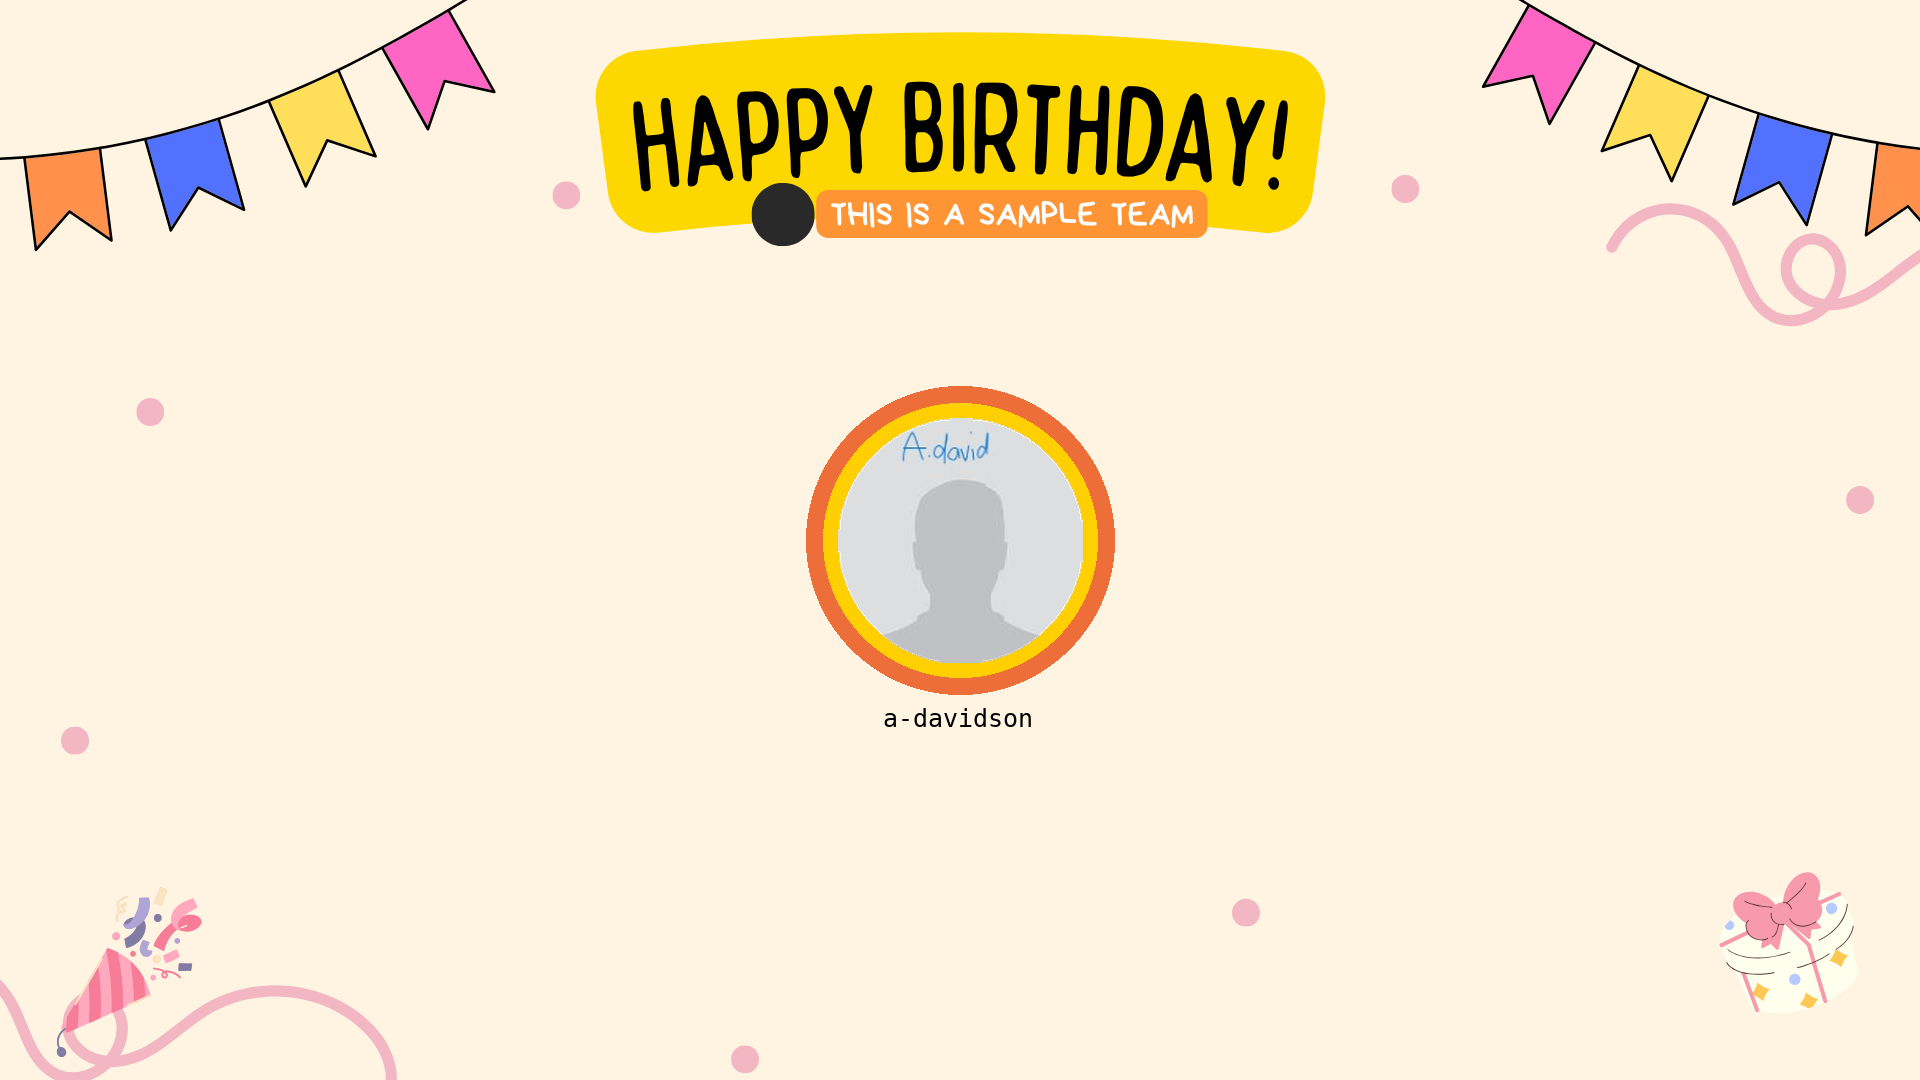

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image_x, image_y = 838, 418
image_size = 245

image = Image.open("backgrounds/bg-0.png")

# Get a drawing context
draw = ImageDraw.Draw(image)


def calculate_border(image_size, image_x, image_y, size_difference, position_offset):

    diameter = image_size + size_difference

    x_coord_diff = y_coord_diff = position_offset
    x_offset = image_x - x_coord_diff
    y_offset = image_y - y_coord_diff

    return diameter, x_offset, y_offset

inner_border_size_offset = 29
inner_border_position_offset = 15

outer_border_size_offset = 63
outer_border_position_offset = 32

inner_diameter, inner_x_offset, inner_y_offest = calculate_border(image_size, image_x, image_y, inner_border_size_offset, inner_border_position_offset)
outer_diameter, outer_x_offset, outer_y_offest = calculate_border(image_size, image_x, image_y, outer_border_size_offset, outer_border_position_offset)


def create_border(diamter, x0, y0):
    x1, y1 = x0 + diamter, y0 + diamter
    bounding_box = x0, y0, x1, y1 
    return bounding_box


# Creation part 
outer_bounding_box = create_border(outer_diameter, outer_x_offset, outer_y_offest)
outer_fill_color = "#ed6e38"
draw.ellipse(outer_bounding_box, fill=outer_fill_color)

inner_bounding_box = create_border(inner_diameter, inner_x_offset, inner_y_offest)
inner_fill_color = "#ffcf00"
draw.ellipse(inner_bounding_box, fill=inner_fill_color)

# Draw the circle using the ellipse method

def make_circular(image_path):
    img = Image.open(image_path).convert("RGBA")
    width, height = img.size

    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, width, height), fill=255)
    img.putalpha(mask)
    return img

# Open the image to paste
circular_image = make_circular("images/a-davidson.jpg")
image_size = 245
resized_image = circular_image.resize((image_size, image_size), Image.LANCZOS)

image_x, image_y = 838, 418
image.paste(resized_image, (image_x, image_y), resized_image)

font = ImageFont.truetype("DejaVuSansMono.ttf", size=25)
x_offset, y_offset = 120, 300
text_position = (image_x + x_offset, image_y + y_offset)
name = "a-davidson"
draw.text(text_position, name, fill="black", font=font, anchor="mm")

image.show()



In [ ]:
# Issue: we should not take the coordianates of the circle in canva manually
# Instead: Calculate it relative to the image coordinates, since we already have that. 
